# Grammatical Evolution for TabNet Hyperparameter Optimization
## Extended Analysis with Ablation Studies and Dimensionality Reduction

This notebook implements a comprehensive analysis framework for breast cancer classification using TabNet optimized via Grammatical Evolution (GE). The analysis includes:

1. GE-based hyperparameter optimization across multiple models
2. Systematic ablation studies for preprocessing, architecture, and training
3. Principal Component Analysis (PCA) for feature space visualization
4. Statistical significance testing and confidence intervals
5. Publication-ready visualizations and LaTeX tables

**Dataset**: Wisconsin Breast Cancer Diagnostic (WBCD)

---

## 1. Environment Setup and Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random
import time
import json
import os
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Any, Tuple, Optional
from dataclasses import dataclass, field
from collections import defaultdict
from copy import deepcopy

from scipy import stats
from scipy.stats import wilcoxon, friedmanchisquare, ttest_rel, mannwhitneyu
from joblib import Parallel, delayed
import multiprocessing

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, matthews_corrcoef, cohen_kappa_score,
    average_precision_score, roc_curve, precision_recall_curve,
    classification_report
)
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# publication-quality settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# optional imports
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    import torch
    HAS_TABNET = True
except ImportError:
    HAS_TABNET = False
    print("[!] TabNet not installed - pip install pytorch-tabnet")

try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("[!] XGBoost not available")

try:
    from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
    from imblearn.combine import SMOTEENN
    HAS_IMBLEARN = True
except ImportError:
    HAS_IMBLEARN = False
    print("[!] imbalanced-learn not available")

try:
    import optuna
    from optuna.samplers import TPESampler
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    HAS_OPTUNA = True
except ImportError:
    HAS_OPTUNA = False

NUM_CORES = max(1, multiprocessing.cpu_count() - 1)

print("="*60)
print("GE-TabNet Extended Analysis Framework")
print(f"Cores available: {NUM_CORES}")
print(f"TabNet: {'OK' if HAS_TABNET else 'Missing'}")
print(f"XGBoost: {'OK' if HAS_XGBOOST else 'Missing'}")
print(f"SMOTE: {'OK' if HAS_IMBLEARN else 'Missing'}")
print("="*60)

GE-TabNet Extended Analysis Framework
Cores available: 7
TabNet: OK
XGBoost: OK
SMOTE: OK


## 2. Configuration

In [2]:
@dataclass
class ExperimentConfig:
    """Central configuration for all experiments."""
    
    # data paths
    DATA_PATH: str = "data.csv"
    TARGET_COL: str = "diagnosis"
    RESULTS_DIR: str = "experiment_results"
    
    # data splits
    TEST_SIZE: float = 0.1
    VAL_SIZE: float = 0.1
    
    # GE parameters
    GE_POP_SIZE: int = 20
    GE_GENERATIONS: int = 30
    GE_CROSSOVER: float = 0.85
    GE_MUTATION: float = 0.15
    GE_TOURNAMENT: int = 3
    GE_ELITISM: int = 2
    
    # TabNet defaults
    TABNET_N_D: int = 64
    TABNET_N_A: int = 64
    TABNET_STEPS: int = 5
    TABNET_GAMMA: float = 1.5
    TABNET_LAMBDA: float = 1e-4
    TABNET_LR: float = 0.02
    TABNET_EPOCHS: int = 150
    TABNET_PATIENCE: int = 30
    TABNET_BATCH: int = 128
    TABNET_MOMENTUM: float = 0.02
    TABNET_MASK: str = 'entmax'
    
    # ablation settings
    ABLATION_FOLDS: int = 5
    N_RUNS: int = 30
    
    # output settings
    SAVE_PLOTS: bool = True
    SHOW_PLOTS: bool = True
    PLOT_DPI: int = 300
    PLOT_FORMAT: str = 'png'
    
    # misc
    SEED: int = 42
    USE_SMOTE: bool = True
    ALPHA: float = 0.05


cfg = ExperimentConfig()
Path(cfg.RESULTS_DIR).mkdir(exist_ok=True, parents=True)

# reproducibility
np.random.seed(cfg.SEED)
random.seed(cfg.SEED)
if HAS_TABNET:
    torch.manual_seed(cfg.SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(cfg.SEED)

## 3. Utility Functions

In [4]:
def confidence_interval(data, alpha=0.95):
    """Compute confidence interval using t-distribution."""
    if len(data) < 2:
        return np.mean(data), np.mean(data)
    n = len(data)
    m = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + alpha) / 2, n - 1)
    return m - h, m + h


def summarize_scores(arr):
    """Return dict of summary statistics."""
    if len(arr) == 0:
        return {'mean': 0, 'std': 0, 'min': 0, 'max': 0, 'median': 0}
    ci_lo, ci_hi = confidence_interval(arr)
    return {
        'mean': float(np.mean(arr)),
        'std': float(np.std(arr)),
        'min': float(np.min(arr)),
        'max': float(np.max(arr)),
        'median': float(np.median(arr)),
        'ci_lower': float(ci_lo),
        'ci_upper': float(ci_hi)
    }


def compute_clinical_metrics(y_true, y_pred):
    """Sensitivity, specificity, PPV, NPV from confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    else:
        sens = spec = ppv = npv = 0
        tn = fp = fn = tp = 0
    return {'sensitivity': sens, 'specificity': spec, 'ppv': ppv, 'npv': npv,
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)}


def full_metrics(y_true, y_pred, y_proba=None):
    """All classification metrics in one call."""
    out = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'kappa': cohen_kappa_score(y_true, y_pred)
    }
    out.update(compute_clinical_metrics(y_true, y_pred))
    if y_proba is not None:
        out['auc'] = roc_auc_score(y_true, y_proba)
        out['avg_precision'] = average_precision_score(y_true, y_proba)
    return out


def paired_significance(s1, s2, test='wilcoxon'):
    """Return (statistic, p-value) for paired samples."""
    if len(s1) != len(s2) or len(s1) < 5:
        return np.nan, np.nan
    try:
        if test == 'wilcoxon':
            stat, p = wilcoxon(s1, s2)
        else:
            stat, p = ttest_rel(s1, s2)
        return float(stat), float(p)
    except:
        return np.nan, np.nan

## 4. Data Loading and Preprocessing

In [6]:
def load_wbcd_data(path, target_col='diagnosis'):
    """Load and preprocess WBCD dataset."""
    df = pd.read_csv(path)
    print(f"Raw data: {df.shape}")
    
    # drop id column if present
    if 'id' in df.columns:
        df = df.drop('id', axis=1)
    if 'Unnamed: 32' in df.columns:
        df = df.drop('Unnamed: 32', axis=1)
    
    # encode target
    le = LabelEncoder()
    y = le.fit_transform(df[target_col])
    X = df.drop(target_col, axis=1).values.astype(np.float32)
    features = df.drop(target_col, axis=1).columns.tolist()
    
    # define feature groups for ablation
    groups = {
        'mean': [i for i, f in enumerate(features) if '_mean' in f],
        'se': [i for i, f in enumerate(features) if '_se' in f],
        'worst': [i for i, f in enumerate(features) if '_worst' in f],
    }
    # size vs shape vs texture
    size_kw = ['radius', 'perimeter', 'area']
    shape_kw = ['compactness', 'concavity', 'concave', 'symmetry', 'fractal']
    texture_kw = ['texture', 'smoothness']
    groups['size'] = [i for i, f in enumerate(features) if any(k in f for k in size_kw)]
    groups['shape'] = [i for i, f in enumerate(features) if any(k in f for k in shape_kw)]
    groups['texture'] = [i for i, f in enumerate(features) if any(k in f for k in texture_kw)]
    
    print(f"Features: {X.shape[1]}  |  Samples: {X.shape[0]}")
    print(f"Class dist: Benign={np.sum(y==0)}, Malignant={np.sum(y==1)}")
    
    return X, y, features, groups


def prepare_splits(X, y, test_size=0.1, val_size=0.1, seed=42):
    """Create train/val/test splits with stratification."""
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=seed)
    adj_val = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=adj_val, stratify=y_temp, random_state=seed)
    
    print(f"Train: {X_train.shape[0]}  Val: {X_val.shape[0]}  Test: {X_test.shape[0]}")
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
X_raw, y, feature_names, feat_groups = load_wbcd_data(cfg.DATA_PATH, cfg.TARGET_COL)

# standard scaling as default
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

X_train, X_val, X_test, y_train, y_val, y_test = prepare_splits(
    X_scaled, y, cfg.TEST_SIZE, cfg.VAL_SIZE, cfg.SEED)

Raw data: (569, 33)
Features: 30  |  Samples: 569
Class dist: Benign=357, Malignant=212
Train: 455  Val: 57  Test: 57


## 5. Principal Component Analysis (PCA)

In [8]:
class PCAAnalyzer:
    """PCA for dimensionality reduction and visualization."""
    
    def __init__(self, n_components=None):
        self.pca = PCA(n_components=n_components)
        self.explained_var = None
        self.cum_var = None
        self.loadings = None
    
    def fit(self, X, feature_names=None):
        self.pca.fit(X)
        self.explained_var = self.pca.explained_variance_ratio_
        self.cum_var = np.cumsum(self.explained_var)
        self.loadings = pd.DataFrame(
            self.pca.components_.T,
            columns=[f'PC{i+1}' for i in range(self.pca.n_components_)],
            index=feature_names if feature_names else [f'F{i}' for i in range(X.shape[1])]
        )
        return self
    
    def transform(self, X):
        return self.pca.transform(X)
    
    def n_for_variance(self, threshold=0.95):
        return int(np.argmax(self.cum_var >= threshold) + 1)
    
    def plot_variance(self, ax=None, show_threshold=0.95):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        n = len(self.explained_var)
        x = np.arange(1, n + 1)
        
        ax.bar(x, self.explained_var * 100, alpha=0.6, label='Individual')
        ax.plot(x, self.cum_var * 100, 'ro-', label='Cumulative')
        ax.axhline(show_threshold * 100, color='gray', ls='--', 
                   label=f'{int(show_threshold*100)}% threshold')
        
        n_thresh = self.n_for_variance(show_threshold)
        ax.axvline(n_thresh, color='green', ls=':', label=f'n={n_thresh}')
        
        ax.set_xlabel('Principal Component')
        ax.set_ylabel('Explained Variance (%)')
        ax.set_title('PCA Explained Variance')
        ax.legend(loc='center right')
        ax.grid(True, alpha=0.3)
        return ax
    
    def plot_biplot(self, X, y, ax=None, n_arrows=10):
        """2D biplot with top loadings."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        
        X_pca = self.transform(X)[:, :2]
        
        colors = ['#3498db', '#e74c3c']
        labels = ['Benign', 'Malignant']
        for cls in [0, 1]:
            mask = y == cls
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[cls],
                      label=labels[cls], alpha=0.6, s=40, edgecolors='w')
        
        # loadings arrows
        load = self.loadings[['PC1', 'PC2']].copy()
        load['magnitude'] = np.sqrt(load['PC1']**2 + load['PC2']**2)
        top_feats = load.nlargest(n_arrows, 'magnitude').index
        
        scale = np.max(np.abs(X_pca)) * 0.7
        for feat in top_feats:
            ax.arrow(0, 0, load.loc[feat, 'PC1'] * scale, 
                    load.loc[feat, 'PC2'] * scale,
                    head_width=0.15, fc='gray', ec='gray', alpha=0.7)
            ax.text(load.loc[feat, 'PC1'] * scale * 1.1,
                   load.loc[feat, 'PC2'] * scale * 1.1,
                   feat, fontsize=8, ha='center')
        
        ax.set_xlabel(f'PC1 ({self.explained_var[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({self.explained_var[1]*100:.1f}%)')
        ax.set_title('PCA Biplot')
        ax.legend()
        ax.axhline(0, color='gray', lw=0.5)
        ax.axvline(0, color='gray', lw=0.5)
        return ax
    
    def plot_loadings_heatmap(self, n_pcs=5, n_feats=15, ax=None):
        """Heatmap of top feature loadings."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        
        load_subset = self.loadings.iloc[:, :n_pcs].copy()
        load_subset['max_abs'] = load_subset.abs().max(axis=1)
        top_idx = load_subset.nlargest(n_feats, 'max_abs').index
        data = load_subset.loc[top_idx].drop('max_abs', axis=1)
        
        sns.heatmap(data, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
                   ax=ax, cbar_kws={'label': 'Loading'})
        ax.set_title('PCA Loadings Heatmap')
        return ax

Components for 95% variance: 10
Components for 99% variance: 17


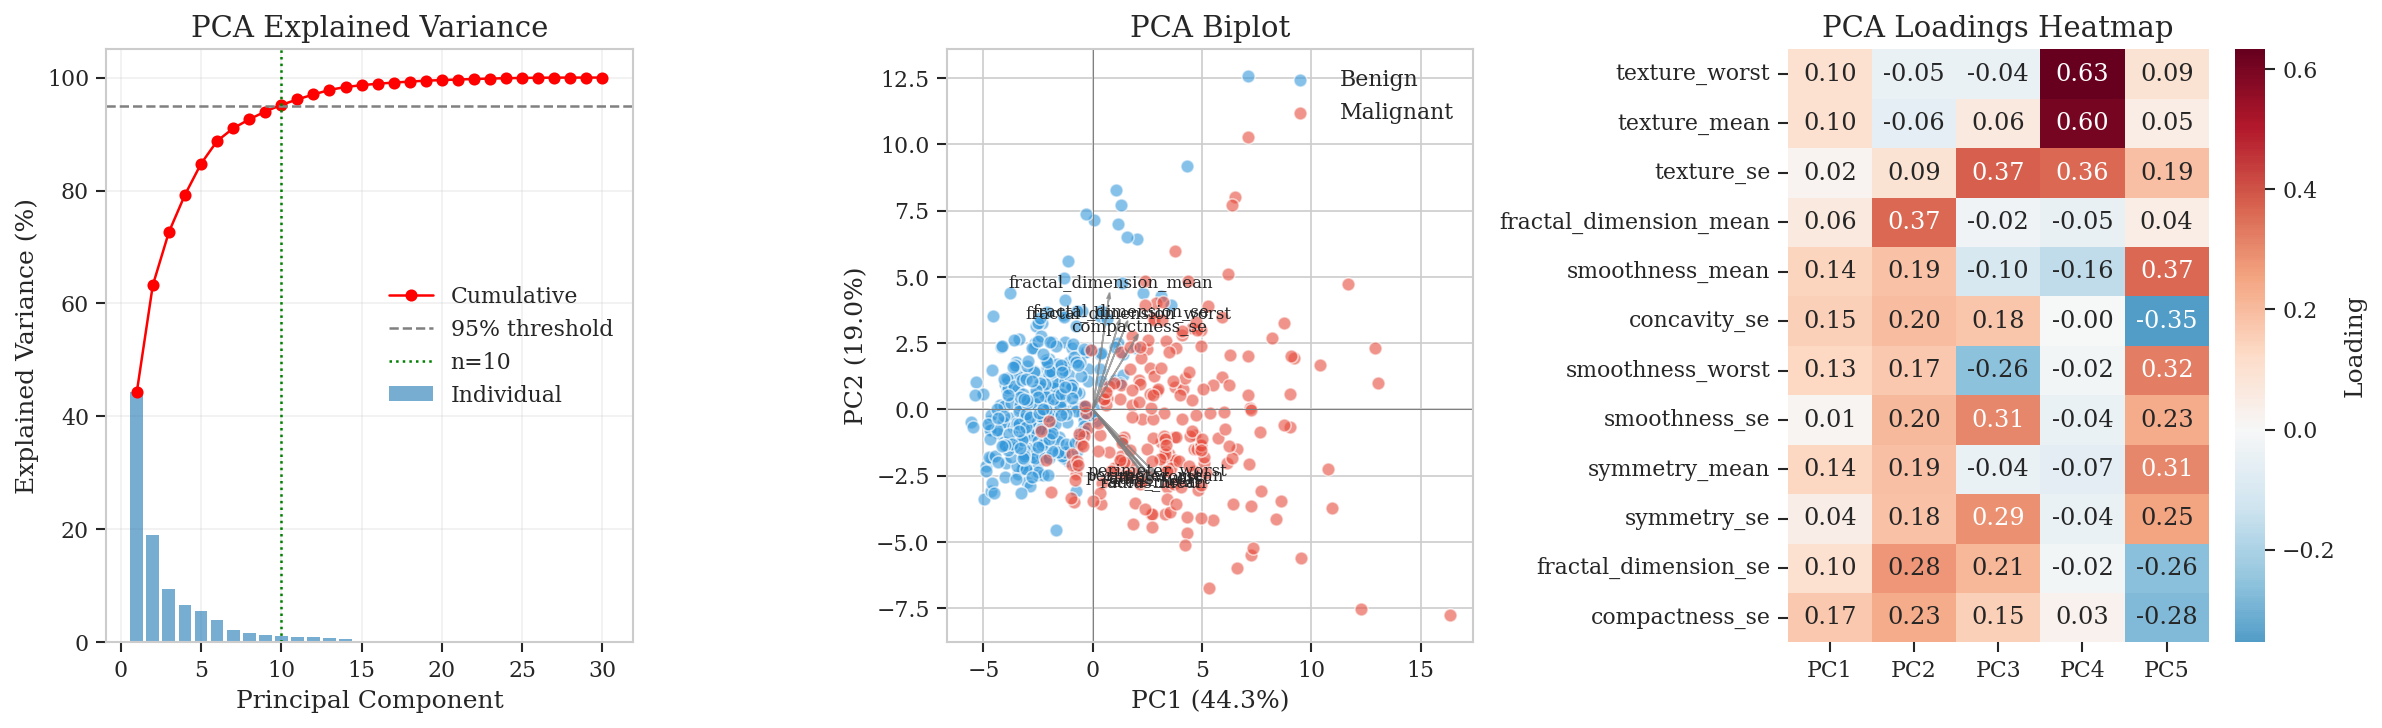

In [9]:
# run PCA on full scaled data
pca_analyzer = PCAAnalyzer().fit(X_scaled, feature_names)

print(f"Components for 95% variance: {pca_analyzer.n_for_variance(0.95)}")
print(f"Components for 99% variance: {pca_analyzer.n_for_variance(0.99)}")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
pca_analyzer.plot_variance(axes[0])
pca_analyzer.plot_biplot(X_scaled, y, axes[1])
pca_analyzer.plot_loadings_heatmap(n_pcs=5, n_feats=12, ax=axes[2])
plt.tight_layout()

if cfg.SAVE_PLOTS:
    plt.savefig(Path(cfg.RESULTS_DIR) / 'pca_analysis.png', dpi=cfg.PLOT_DPI)
plt.show()

## 6. Grammatical Evolution Framework

In [10]:
class BNFGrammar:
    """Parse BNF grammar for GE."""
    
    def __init__(self, grammar_str):
        self.rules = {}
        self._parse(grammar_str)
    
    def _parse(self, txt):
        for line in txt.strip().split('\n'):
            line = line.strip()
            if not line or '::=' not in line:
                continue
            lhs, rhs = line.split('::=')
            nt = lhs.strip().strip('<>')
            choices = [c.strip() for c in rhs.split('|')]
            self.rules[nt] = choices
    
    def decode(self, chromosome):
        """Map chromosome to hyperparameter dict."""
        params = {}
        idx = 0
        for nt, choices in self.rules.items():
            if idx >= len(chromosome):
                break
            pick = chromosome[idx] % len(choices)
            val_str = choices[pick]
            # parse value
            try:
                if val_str == 'None':
                    val = None
                elif 'e-' in val_str or 'e+' in val_str or '.' in val_str:
                    val = float(val_str)
                elif val_str.isdigit() or (val_str[0] == '-' and val_str[1:].isdigit()):
                    val = int(val_str)
                else:
                    val = val_str
            except:
                val = val_str
            params[nt] = val
            idx += 1
        return params
    
    def get_nonterminals(self):
        return list(self.rules.keys())


def make_tabnet_grammar():
    return BNFGrammar("""
<n_d> ::= 8 | 16 | 32 | 64
<n_a> ::= 8 | 16 | 32 | 64
<n_steps> ::= 3 | 5 | 7
<lambda_sparse> ::= 1e-4 | 1e-3 | 1e-2
""")


def make_rf_grammar():
    return BNFGrammar("""
<n_estimators> ::= 100 | 200 | 300
<max_depth> ::= 5 | 10 | 15 | None
""")


def make_xgb_grammar():
    return BNFGrammar("""
<n_estimators> ::= 100 | 200 | 300
<learning_rate> ::= 0.01 | 0.05 | 0.1
<max_depth> ::= 3 | 5 | 7
""")

In [ ]:
@dataclass
class GEResult:
    best_config: Dict
    best_fitness: float
    history: Dict
    generations: int
    evals: int
    runtime: float


class GEOptimizer:
    """Grammatical Evolution optimizer."""
    
    def __init__(self, grammar, fitness_fn, pop_size=20, generations=30,
                 crossover=0.85, mutation=0.15, tournament=3, elitism=2,
                 maximize=True, seed=42, verbose=True):
        self.grammar = grammar
        self.fitness_fn = fitness_fn
        self.pop_size = pop_size
        self.generations = generations
        self.crossover = crossover
        self.mutation = mutation
        self.tournament = tournament
        self.elitism = elitism
        self.maximize = maximize
        self.seed = seed
        self.verbose = verbose
        
        self.chr_len = len(grammar.get_nonterminals()) * 4
        self.history = {'best': [], 'avg': []}
    
    def _init_pop(self, rng):
        return [rng.integers(0, 256, size=self.chr_len).tolist() 
                for _ in range(self.pop_size)]
    
    def _evaluate(self, chrom):
        params = self.grammar.decode(chrom)
        return self.fitness_fn(params)
    
    def _tournament_select(self, pop, scores, rng):
        idx = rng.choice(len(pop), size=self.tournament, replace=False)
        if self.maximize:
            win = idx[np.argmax([scores[i] for i in idx])]
        else:
            win = idx[np.argmin([scores[i] for i in idx])]
        return pop[win]
    
    def _crossover(self, p1, p2, rng):
        if rng.random() > self.crossover:
            return p1[:], p2[:]
        pt = rng.integers(1, len(p1))
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
        return c1, c2
    
    def _mutate(self, chrom, rng):
        out = chrom[:]
        for i in range(len(out)):
            if rng.random() < self.mutation:
                out[i] = rng.integers(0, 256)
        return out
    
    def evolve(self):
        rng = np.random.default_rng(self.seed)
        pop = self._init_pop(rng)
        t0 = time.time()
        total_evals = 0
        
        best_ever = (None, float('-inf') if self.maximize else float('inf'), None)
        
        for gen in range(self.generations):
            scores = [self._evaluate(c) for c in pop]
            total_evals += len(pop)
            
            for i, (c, s) in enumerate(zip(pop, scores)):
                if (self.maximize and s > best_ever[1]) or \
                   (not self.maximize and s < best_ever[1]):
                    best_ever = (c[:], s, self.grammar.decode(c))
            
            self.history['best'].append(best_ever[1])
            self.history['avg'].append(float(np.mean(scores)))
            
            if self.verbose and gen % 5 == 0:
                print(f"  Gen {gen}: best={best_ever[1]:.4f}")
            
            # selection and reproduction
            elite_idx = np.argsort(scores)[-self.elitism:] if self.maximize \
                       else np.argsort(scores)[:self.elitism]
            new_pop = [pop[i][:] for i in elite_idx]
            
            while len(new_pop) < self.pop_size:
                p1 = self._tournament_select(pop, scores, rng)
                p2 = self._tournament_select(pop, scores, rng)
                c1, c2 = self._crossover(p1, p2, rng)
                new_pop.append(self._mutate(c1, rng))
                if len(new_pop) < self.pop_size:
                    new_pop.append(self._mutate(c2, rng))
            
            pop = new_pop
        
        return GEResult(
            best_config=best_ever[2],
            best_fitness=best_ever[1],
            history=self.history,
            generations=self.generations,
            evals=total_evals,
            runtime=time.time() - t0
        )

## 7. Model Trainers

In [13]:
class TabNetTrainer:
    """TabNet training wrapper with SMOTE."""
    
    def __init__(self, X_tr, y_tr, X_val, y_val, X_test, y_test, config):
        self.X_tr = X_tr
        self.y_tr = y_tr
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.cfg = config
    
    def fitness(self, params, seed_off=0):
        """Evaluate params, return validation AUC."""
        try:
            X_t, y_t = self.X_tr.copy(), self.y_tr.copy()
            if self.cfg.USE_SMOTE and HAS_IMBLEARN:
                sm = SMOTE(random_state=self.cfg.SEED + seed_off)
                X_t, y_t = sm.fit_resample(X_t, y_t)
            
            model = TabNetClassifier(
                n_d=params.get('n_d', self.cfg.TABNET_N_D),
                n_a=params.get('n_a', self.cfg.TABNET_N_A),
                n_steps=params.get('n_steps', self.cfg.TABNET_STEPS),
                gamma=self.cfg.TABNET_GAMMA,
                lambda_sparse=params.get('lambda_sparse', self.cfg.TABNET_LAMBDA),
                momentum=self.cfg.TABNET_MOMENTUM,
                mask_type=self.cfg.TABNET_MASK,
                verbose=0,
                seed=self.cfg.SEED + seed_off
            )
            
            model.fit(
                X_t, y_t,
                eval_set=[(self.X_val, self.y_val)],
                eval_metric=['auc'],
                max_epochs=self.cfg.TABNET_EPOCHS,
                patience=self.cfg.TABNET_PATIENCE,
                batch_size=self.cfg.TABNET_BATCH,
                virtual_batch_size=64,
                drop_last=False
            )
            
            proba = model.predict_proba(self.X_val)[:, 1]
            return roc_auc_score(self.y_val, proba)
        except Exception as e:
            return 0.0
    
    def train_final(self, params, seed=42):
        """Train on train+val, evaluate on test."""
        X_full = np.vstack([self.X_tr, self.X_val])
        y_full = np.concatenate([self.y_tr, self.y_val])
        
        if self.cfg.USE_SMOTE and HAS_IMBLEARN:
            sm = SMOTE(random_state=seed)
            X_full, y_full = sm.fit_resample(X_full, y_full)
        
        model = TabNetClassifier(
            n_d=params.get('n_d', self.cfg.TABNET_N_D),
            n_a=params.get('n_a', self.cfg.TABNET_N_A),
            n_steps=params.get('n_steps', self.cfg.TABNET_STEPS),
            gamma=params.get('gamma', self.cfg.TABNET_GAMMA),
            lambda_sparse=params.get('lambda_sparse', self.cfg.TABNET_LAMBDA),
            momentum=self.cfg.TABNET_MOMENTUM,
            mask_type=self.cfg.TABNET_MASK,
            verbose=0,
            seed=seed
        )
        
        X_t, X_es, y_t, y_es = train_test_split(
            X_full, y_full, test_size=0.1, stratify=y_full, random_state=seed)
        
        model.fit(
            X_t, y_t,
            eval_set=[(X_es, y_es)],
            eval_metric=['auc'],
            max_epochs=self.cfg.TABNET_EPOCHS,
            patience=self.cfg.TABNET_PATIENCE,
            batch_size=self.cfg.TABNET_BATCH,
            virtual_batch_size=64,
            drop_last=False
        )
        
        y_pred = model.predict(self.X_test)
        y_proba = model.predict_proba(self.X_test)[:, 1]
        
        return model, full_metrics(self.y_test, y_pred, y_proba)

In [15]:
class BaselineTrainer:
    """Train baseline ML models with GE."""
    
    MODEL_FIXED = {
        'RF': {'max_features': 'sqrt', 'min_samples_split': 2, 'n_jobs': -1},
        'LR': {'max_iter': 1000, 'solver': 'lbfgs'},
        'SVM': {'gamma': 'scale', 'probability': True},
        'GB': {'subsample': 0.8},
        'XGB': {'subsample': 0.8, 'colsample_bytree': 0.8, 'use_label_encoder': False, 
                'eval_metric': 'logloss'}
    }
    
    GRAMMARS = {
        'RF': make_rf_grammar,
        'XGB': make_xgb_grammar,
    }
    
    def __init__(self, X_tr, y_tr, X_val, y_val, X_test, y_test, config):
        self.X_tr = X_tr
        self.y_tr = y_tr
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.cfg = config
    
    def _get_model(self, name, params):
        fixed = self.MODEL_FIXED.get(name, {})
        merged = {**fixed, **params}
        
        if name == 'RF':
            return RandomForestClassifier(**merged, random_state=self.cfg.SEED)
        elif name == 'XGB' and HAS_XGBOOST:
            return XGBClassifier(**merged, random_state=self.cfg.SEED)
        elif name == 'SVM':
            return SVC(**merged, random_state=self.cfg.SEED)
        elif name == 'LR':
            return LogisticRegression(**merged, random_state=self.cfg.SEED)
        elif name == 'GB':
            return GradientBoostingClassifier(**merged, random_state=self.cfg.SEED)
        return None
    
    def fitness(self, name, params, seed_off=0):
        try:
            X_t, y_t = self.X_tr.copy(), self.y_tr.copy()
            if self.cfg.USE_SMOTE and HAS_IMBLEARN:
                sm = SMOTE(random_state=self.cfg.SEED + seed_off)
                X_t, y_t = sm.fit_resample(X_t, y_t)
            
            model = self._get_model(name, params)
            model.fit(X_t, y_t)
            
            if hasattr(model, 'predict_proba'):
                proba = model.predict_proba(self.X_val)[:, 1]
            else:
                proba = model.decision_function(self.X_val)
            
            return roc_auc_score(self.y_val, proba)
        except:
            return 0.0
    
    def train_final(self, name, params, seed=42):
        X_full = np.vstack([self.X_tr, self.X_val])
        y_full = np.concatenate([self.y_tr, self.y_val])
        
        if self.cfg.USE_SMOTE and HAS_IMBLEARN:
            sm = SMOTE(random_state=seed)
            X_full, y_full = sm.fit_resample(X_full, y_full)
        
        model = self._get_model(name, params)
        model.fit(X_full, y_full)
        
        y_pred = model.predict(self.X_test)
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(self.X_test)[:, 1]
        else:
            y_proba = model.decision_function(self.X_test)
        
        return model, full_metrics(self.y_test, y_pred, y_proba)

## 8. Ablation Study Framework

In [16]:
@dataclass
class AblationResult:
    name: str
    variant: str
    metrics: Dict[str, float]
    std: Dict[str, float]
    time_sec: float
    n_folds: int
    extra: Dict = field(default_factory=dict)


class AblationStudy:
    """Systematic ablation experiments."""
    
    def __init__(self, X_train, y_train, feature_names, feat_groups, config):
        self.X = X_train
        self.y = y_train
        self.feat_names = feature_names
        self.groups = feat_groups
        self.cfg = config
        self.results = defaultdict(list)
        self.baselines = {}
    
    def _cv_eval(self, model_fn, X, y, use_smote=False):
        """K-fold CV returning mean/std metrics."""
        kf = StratifiedKFold(n_splits=self.cfg.ABLATION_FOLDS, shuffle=True, 
                             random_state=self.cfg.SEED)
        fold_metrics = []
        t0 = time.time()
        
        for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
            X_tr, X_val = X[tr_idx], X[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]
            
            if use_smote and HAS_IMBLEARN:
                sm = SMOTE(random_state=self.cfg.SEED + fold)
                X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
            
            try:
                model = model_fn()
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y_val)],
                    eval_metric=['auc'],
                    max_epochs=self.cfg.TABNET_EPOCHS,
                    patience=self.cfg.TABNET_PATIENCE,
                    batch_size=self.cfg.TABNET_BATCH,
                    drop_last=False
                )
                y_pred = model.predict(X_val)
                y_proba = model.predict_proba(X_val)[:, 1]
                fold_metrics.append(full_metrics(y_val, y_pred, y_proba))
            except Exception as e:
                continue
        
        elapsed = time.time() - t0
        if not fold_metrics:
            return {}, {}, elapsed
        
        mean_m = {k: np.mean([f[k] for f in fold_metrics]) for k in fold_metrics[0]}
        std_m = {k: np.std([f[k] for f in fold_metrics]) for k in fold_metrics[0]}
        return mean_m, std_m, elapsed
    
    def run_preprocessing(self):
        """Ablation: preprocessing methods."""
        exp = "Preprocessing"
        print(f"\n{'='*60}\nABLATION: {exp}\n{'='*60}")
        
        # get raw X
        X_raw = self.X.copy()  # assume already scaled
        
        variants = {
            'StandardScaler': StandardScaler(),
            'MinMaxScaler': MinMaxScaler(),
            'RobustScaler': RobustScaler(),
            'StandardScaler+SMOTE': (StandardScaler(), True),
        }
        
        def make_tabnet():
            return TabNetClassifier(
                n_d=self.cfg.TABNET_N_D, n_a=self.cfg.TABNET_N_A,
                n_steps=self.cfg.TABNET_STEPS, gamma=self.cfg.TABNET_GAMMA,
                lambda_sparse=self.cfg.TABNET_LAMBDA, momentum=self.cfg.TABNET_MOMENTUM,
                verbose=0, seed=self.cfg.SEED
            )
        
        for vname, scaler_cfg in variants.items():
            print(f"  {vname}...", end=" ", flush=True)
            
            if isinstance(scaler_cfg, tuple):
                scaler, smote = scaler_cfg
            else:
                scaler, smote = scaler_cfg, False
            
            X_s = scaler.fit_transform(X_raw)
            mean_m, std_m, elapsed = self._cv_eval(make_tabnet, X_s, self.y, smote)
            
            if mean_m:
                res = AblationResult(exp, vname, mean_m, std_m, elapsed, self.cfg.ABLATION_FOLDS)
                self.results[exp].append(res)
                if 'StandardScaler' == vname:
                    self.baselines[exp] = res
                print(f"Acc={mean_m['accuracy']:.4f} AUC={mean_m['auc']:.4f}")
            else:
                print("failed")
    
    def run_architecture(self):
        """Ablation: TabNet architecture."""
        exp = "Architecture"
        print(f"\n{'='*60}\nABLATION: {exp}\n{'='*60}")
        
        variants = {
            'n_d=32': {'n_d': 32, 'n_a': 32},
            'n_d=64 (baseline)': {'n_d': 64, 'n_a': 64},
            'n_d=128': {'n_d': 128, 'n_a': 128},
            'n_steps=3': {'n_steps': 3},
            'n_steps=5': {'n_steps': 5},
            'n_steps=7': {'n_steps': 7},
            'gamma=1.0': {'gamma': 1.0},
            'gamma=1.5': {'gamma': 1.5},
            'gamma=2.0': {'gamma': 2.0},
            'lambda=1e-3': {'lambda_sparse': 1e-3},
            'lambda=1e-4': {'lambda_sparse': 1e-4},
            'lambda=1e-5': {'lambda_sparse': 1e-5},
            'mask=sparsemax': {'mask_type': 'sparsemax'},
            'mask=entmax': {'mask_type': 'entmax'},
        }
        
        base = {
            'n_d': self.cfg.TABNET_N_D, 'n_a': self.cfg.TABNET_N_A,
            'n_steps': self.cfg.TABNET_STEPS, 'gamma': self.cfg.TABNET_GAMMA,
            'lambda_sparse': self.cfg.TABNET_LAMBDA, 'mask_type': 'sparsemax',
            'momentum': self.cfg.TABNET_MOMENTUM, 'verbose': 0, 'seed': self.cfg.SEED
        }
        
        for vname, params in variants.items():
            print(f"  {vname}...", end=" ", flush=True)
            merged = {**base, **params}
            
            def make_model(p=merged):
                return TabNetClassifier(**p)
            
            mean_m, std_m, elapsed = self._cv_eval(make_model, self.X, self.y)
            if mean_m:
                res = AblationResult(exp, vname, mean_m, std_m, elapsed, 
                                    self.cfg.ABLATION_FOLDS, extra=params)
                self.results[exp].append(res)
                if 'baseline' in vname:
                    self.baselines[exp] = res
                print(f"Acc={mean_m['accuracy']:.4f} AUC={mean_m['auc']:.4f}")
            else:
                print("failed")
    
    def run_features(self):
        """Ablation: feature groups."""
        exp = "Features"
        print(f"\n{'='*60}\nABLATION: {exp}\n{'='*60}")
        
        def make_tabnet():
            return TabNetClassifier(
                n_d=self.cfg.TABNET_N_D, n_a=self.cfg.TABNET_N_A,
                n_steps=self.cfg.TABNET_STEPS, gamma=self.cfg.TABNET_GAMMA,
                lambda_sparse=self.cfg.TABNET_LAMBDA, momentum=self.cfg.TABNET_MOMENTUM,
                verbose=0, seed=self.cfg.SEED
            )
        
        # all features
        print(f"  All features (n={self.X.shape[1]})...", end=" ", flush=True)
        mean_m, std_m, elapsed = self._cv_eval(make_tabnet, self.X, self.y)
        if mean_m:
            res = AblationResult(exp, f"All (n={self.X.shape[1]})", mean_m, std_m, 
                               elapsed, self.cfg.ABLATION_FOLDS)
            self.results[exp].append(res)
            self.baselines[exp] = res
            print(f"Acc={mean_m['accuracy']:.4f} AUC={mean_m['auc']:.4f}")
        
        # by group
        for gname, idx in self.groups.items():
            if not idx:
                continue
            print(f"  {gname} (n={len(idx)})...", end=" ", flush=True)
            X_sub = self.X[:, idx]
            mean_m, std_m, elapsed = self._cv_eval(make_tabnet, X_sub, self.y)
            if mean_m:
                res = AblationResult(exp, f"{gname} (n={len(idx)})", mean_m, std_m,
                                   elapsed, self.cfg.ABLATION_FOLDS)
                self.results[exp].append(res)
                print(f"Acc={mean_m['accuracy']:.4f} AUC={mean_m['auc']:.4f}")
            else:
                print("failed")
    
    def run_all(self):
        self.run_preprocessing()
        self.run_architecture()
        self.run_features()
        return self.results
    
    def to_dataframe(self):
        rows = []
        for exp, results in self.results.items():
            for r in results:
                row = {'Experiment': exp, 'Variant': r.variant, 'Time': r.time_sec}
                for k, v in r.metrics.items():
                    row[k] = v
                    row[f"{k}_std"] = r.std.get(k, 0)
                rows.append(row)
        return pd.DataFrame(rows)

In [17]:
if HAS_TABNET:
    ablation = AblationStudy(X_train, y_train, feature_names, feat_groups, cfg)
    ablation_results = ablation.run_all()
    abl_df = ablation.to_dataframe()
    print("\nAblation Summary:")
    print(abl_df[['Experiment', 'Variant', 'accuracy', 'auc']].to_string(index=False))
else:
    print("TabNet not available - skipping ablation")


ABLATION: Preprocessing
  StandardScaler... 
Early stopping occurred at epoch 115 with best_epoch = 85 and best_val_0_auc = 0.99948

Early stopping occurred at epoch 48 with best_epoch = 18 and best_val_0_auc = 0.98504

Early stopping occurred at epoch 41 with best_epoch = 11 and best_val_0_auc = 0.99742

Early stopping occurred at epoch 87 with best_epoch = 57 and best_val_0_auc = 0.99639

Early stopping occurred at epoch 96 with best_epoch = 66 and best_val_0_auc = 0.99536
Acc=0.9516 AUC=0.9947
  MinMaxScaler... 
Early stopping occurred at epoch 115 with best_epoch = 85 and best_val_0_auc = 0.99587

Early stopping occurred at epoch 70 with best_epoch = 40 and best_val_0_auc = 0.98607

Early stopping occurred at epoch 58 with best_epoch = 28 and best_val_0_auc = 1.0

Early stopping occurred at epoch 65 with best_epoch = 35 and best_val_0_auc = 0.99794

Early stopping occurred at epoch 117 with best_epoch = 87 and best_val_0_auc = 1.0
Acc=0.7780 AUC=0.9960
  RobustScaler... 
Early sto

## 9. GE Optimization Run

In [19]:
def run_ge_optimization(trainer, grammar, n_runs=5, config=None):
    """Run GE optimization multiple times."""
    all_results = []
    
    for run in range(n_runs):
        seed = config.SEED + run * 1000
        
        def fitness_fn(params):
            return trainer.fitness(params, seed_off=run*100)
        
        opt = GEOptimizer(
            grammar=grammar,
            fitness_fn=fitness_fn,
            pop_size=config.GE_POP_SIZE,
            generations=config.GE_GENERATIONS,
            crossover=config.GE_CROSSOVER,
            mutation=config.GE_MUTATION,
            tournament=config.GE_TOURNAMENT,
            elitism=config.GE_ELITISM,
            maximize=True,
            seed=seed,
            verbose=False
        )
        
        result = opt.evolve()
        all_results.append(result)
        print(f"  Run {run+1}/{n_runs}: best={result.best_fitness:.4f}")
    
    return all_results

In [20]:
if HAS_TABNET:
    print("\nRunning GE-TabNet optimization...")
    trainer = TabNetTrainer(X_train, y_train, X_val, y_val, X_test, y_test, cfg)
    grammar = make_tabnet_grammar()
    
    # reduce runs for demo
    ge_results = run_ge_optimization(trainer, grammar, n_runs=5, config=cfg)
    
    # find best
    best_run = max(ge_results, key=lambda r: r.best_fitness)
    print(f"\nBest config: {best_run.best_config}")
    print(f"Best val AUC: {best_run.best_fitness:.4f}")
    
    # train final
    print("\nTraining final model...")
    final_model, final_metrics = trainer.train_final(best_run.best_config)
    print(f"Test AUC: {final_metrics['auc']:.4f}")
    print(f"Test Acc: {final_metrics['accuracy']:.4f}")
else:
    print("Skipping GE optimization - TabNet not available")


Running GE-TabNet optimization...

Early stopping occurred at epoch 44 with best_epoch = 14 and best_val_0_auc = 0.99735

Early stopping occurred at epoch 39 with best_epoch = 9 and best_val_0_auc = 0.99471

Early stopping occurred at epoch 57 with best_epoch = 27 and best_val_0_auc = 1.0

Early stopping occurred at epoch 58 with best_epoch = 28 and best_val_0_auc = 0.99735

Early stopping occurred at epoch 44 with best_epoch = 14 and best_val_0_auc = 0.99339

Early stopping occurred at epoch 76 with best_epoch = 46 and best_val_0_auc = 0.99868

Early stopping occurred at epoch 83 with best_epoch = 53 and best_val_0_auc = 0.99471

Early stopping occurred at epoch 36 with best_epoch = 6 and best_val_0_auc = 0.99339

Early stopping occurred at epoch 47 with best_epoch = 17 and best_val_0_auc = 1.0

Early stopping occurred at epoch 67 with best_epoch = 37 and best_val_0_auc = 0.99471

Early stopping occurred at epoch 63 with best_epoch = 33 and best_val_0_auc = 0.99735

Early stopping oc

## 10. Publication Visualizations

In [21]:
def plot_convergence(ge_results, save_path=None):
    """Plot GE convergence curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # best fitness
    ax = axes[0]
    for i, res in enumerate(ge_results):
        ax.plot(res.history['best'], alpha=0.5, label=f'Run {i+1}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Fitness (AUC)')
    ax.set_title('Convergence: Best Fitness')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # avg fitness
    ax = axes[1]
    for i, res in enumerate(ge_results):
        ax.plot(res.history['avg'], alpha=0.5, label=f'Run {i+1}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Average Fitness')
    ax.set_title('Convergence: Population Average')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_ablation_summary(ablation_df, save_path=None):
    """Bar chart of ablation results."""
    experiments = ablation_df['Experiment'].unique()
    n_exp = len(experiments)
    
    fig, axes = plt.subplots(1, n_exp, figsize=(5*n_exp, 5))
    if n_exp == 1:
        axes = [axes]
    
    for ax, exp in zip(axes, experiments):
        subset = ablation_df[ablation_df['Experiment'] == exp]
        variants = subset['Variant'].values
        aucs = subset['auc'].values
        stds = subset.get('auc_std', np.zeros(len(aucs))).values
        
        colors = plt.cm.Set2(np.linspace(0, 1, len(variants)))
        bars = ax.barh(variants, aucs, xerr=stds, color=colors,
                      edgecolor='black', capsize=3)
        
        for bar, val in zip(bars, aucs):
            ax.text(val + 0.005, bar.get_y() + bar.get_height()/2,
                   f'{val:.3f}', va='center', fontsize=8)
        
        ax.set_xlabel('AUC')
        ax.set_title(f'{exp}')
        ax.set_xlim([0.9, 1.0])
        ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_roc_curves(y_true, predictions_dict, save_path=None):
    """ROC curves for multiple models."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(predictions_dict)))
    
    for (name, y_proba), color in zip(predictions_dict.items(), colors):
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_val = roc_auc_score(y_true, y_proba)
        ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC={auc_val:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves Comparison')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

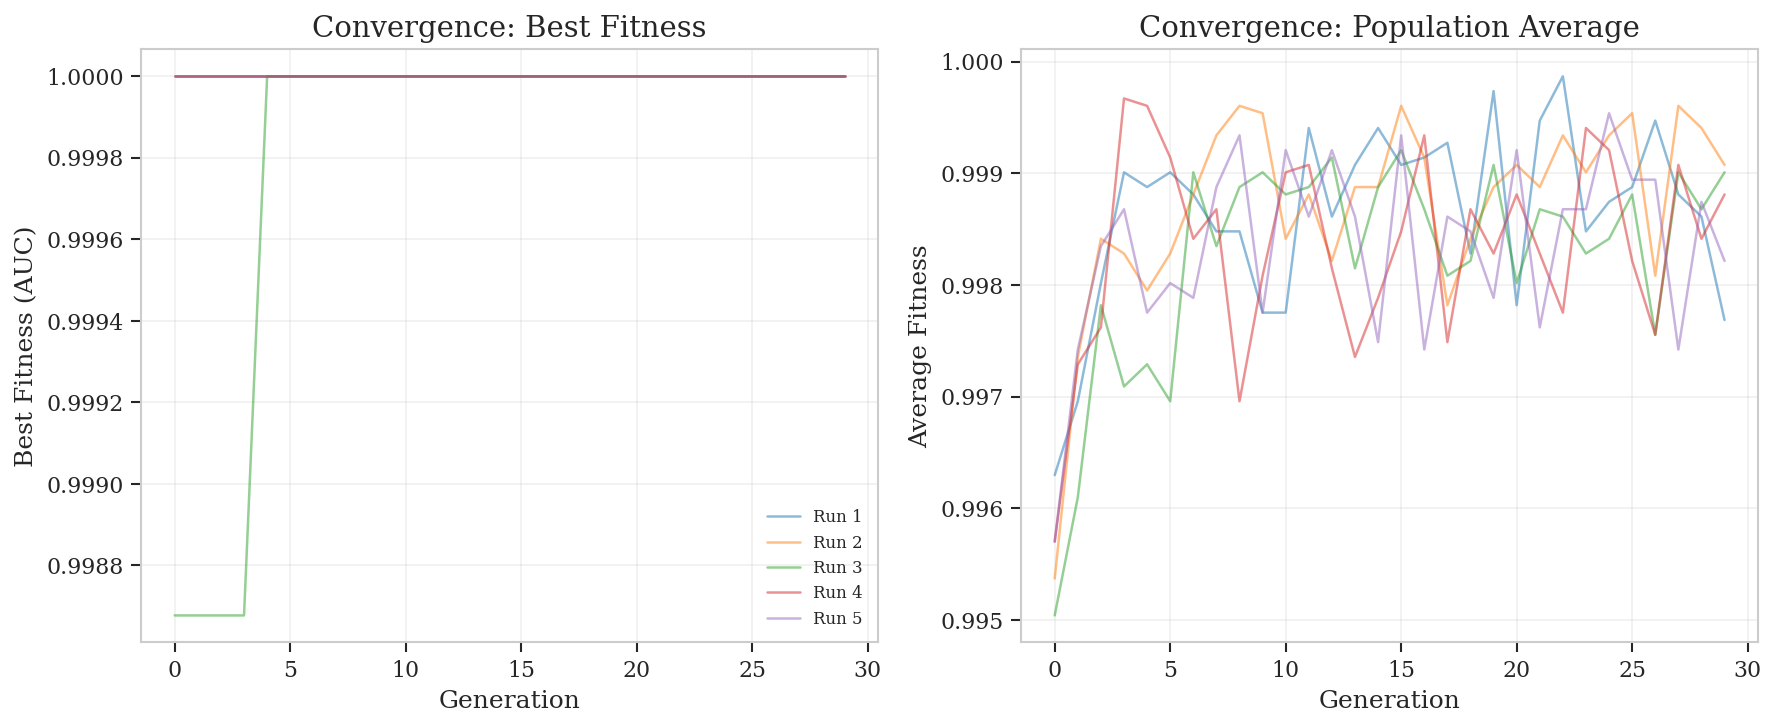

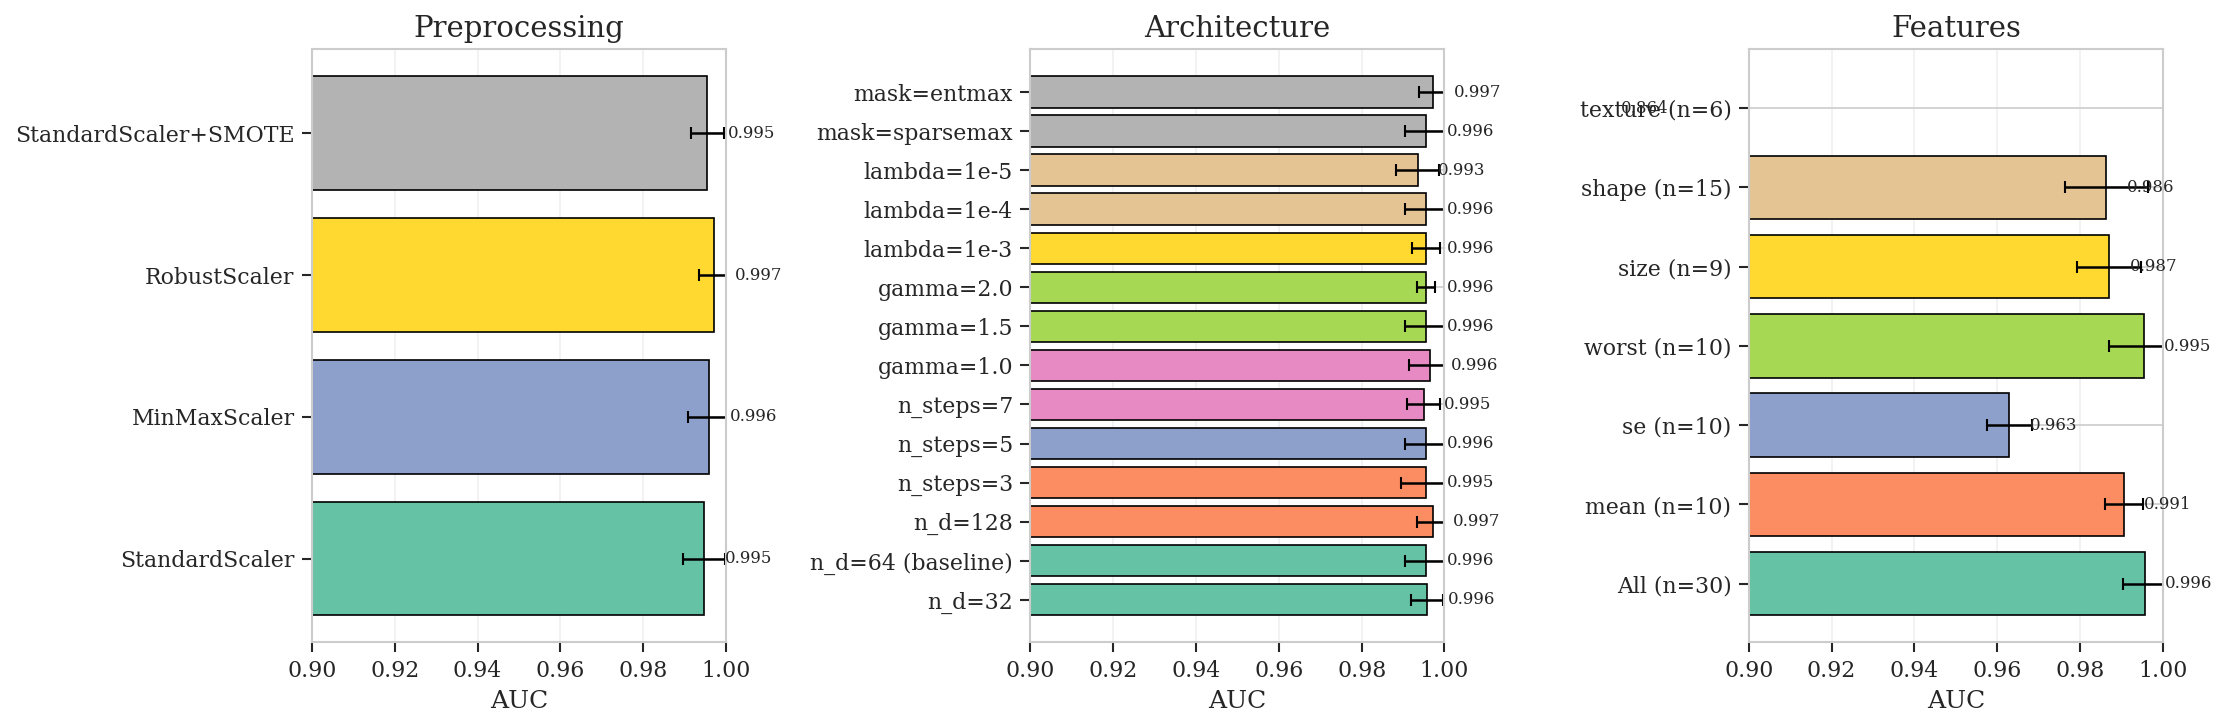

In [22]:
if HAS_TABNET and 'ge_results' in dir():
    plot_convergence(ge_results, Path(cfg.RESULTS_DIR) / 'ge_convergence.png')

if 'abl_df' in dir() and not abl_df.empty:
    plot_ablation_summary(abl_df, Path(cfg.RESULTS_DIR) / 'ablation_summary.png')

## 11. LaTeX Tables Export

In [23]:
def generate_latex_table(df, caption, label, columns=None):
    """Generate LaTeX table from DataFrame."""
    if columns:
        df = df[columns]
    
    lines = [
        "\\begin{table}[htbp]",
        "\\centering",
        f"\\caption{{{caption}}}",
        f"\\label{{{label}}}",
        "\\begin{tabular}{" + "l" + "c"*(len(df.columns)-1) + "}",
        "\\toprule",
        " & ".join(df.columns) + " \\\\",
        "\\midrule"
    ]
    
    for _, row in df.iterrows():
        vals = []
        for v in row:
            if isinstance(v, float):
                vals.append(f"{v:.4f}")
            else:
                vals.append(str(v))
        lines.append(" & ".join(vals) + " \\\\")
    
    lines.extend([
        "\\bottomrule",
        "\\end{tabular}",
        "\\end{table}"
    ])
    
    return "\n".join(lines)


def export_all_tables(ablation_df, output_dir):
    """Export all results as LaTeX."""
    output = ["% Auto-generated LaTeX tables\n"]
    
    for exp in ablation_df['Experiment'].unique():
        subset = ablation_df[ablation_df['Experiment'] == exp]
        cols = ['Variant', 'accuracy', 'auc', 'f1', 'sensitivity', 'specificity']
        cols = [c for c in cols if c in subset.columns]
        
        table = generate_latex_table(
            subset[cols],
            f"Ablation Study: {exp}",
            f"tab:{exp.lower().replace(' ', '_')}"
        )
        output.append(table)
        output.append("\n")
    
    with open(Path(output_dir) / 'tables.tex', 'w') as f:
        f.write("\n".join(output))
    print(f"LaTeX tables saved to {output_dir}/tables.tex")

In [24]:
if 'abl_df' in dir() and not abl_df.empty:
    export_all_tables(abl_df, cfg.RESULTS_DIR)

LaTeX tables saved to experiment_results/tables.tex


## 12. Statistical Analysis

In [25]:
def statistical_comparison(scores_dict, alpha=0.05):
    """Pairwise Wilcoxon tests between methods."""
    methods = list(scores_dict.keys())
    n = len(methods)
    results = []
    
    for i in range(n):
        for j in range(i+1, n):
            m1, m2 = methods[i], methods[j]
            s1, s2 = scores_dict[m1], scores_dict[m2]
            
            if len(s1) != len(s2) or len(s1) < 5:
                continue
            
            stat, p = wilcoxon(s1, s2)
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            
            results.append({
                'Comparison': f"{m1} vs {m2}",
                'Mean1': np.mean(s1),
                'Mean2': np.mean(s2),
                'Diff': np.mean(s1) - np.mean(s2),
                'W-stat': stat,
                'p-value': p,
                'Sig': sig
            })
    
    return pd.DataFrame(results)


def effect_size_cohens_d(g1, g2):
    """Cohen's d effect size."""
    n1, n2 = len(g1), len(g2)
    var1, var2 = np.var(g1, ddof=1), np.var(g2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(g1) - np.mean(g2)) / pooled_std if pooled_std > 0 else 0

In [26]:
# example with GE run scores
if HAS_TABNET and 'ge_results' in dir():
    ge_scores = [r.best_fitness for r in ge_results]
    print(f"GE Optimization Summary:")
    print(f"  Mean AUC: {np.mean(ge_scores):.4f} +/- {np.std(ge_scores):.4f}")
    ci_lo, ci_hi = confidence_interval(ge_scores)
    print(f"  95% CI: [{ci_lo:.4f}, {ci_hi:.4f}]")

GE Optimization Summary:
  Mean AUC: 1.0000 +/- 0.0000
  95% CI: [1.0000, 1.0000]


## 13. Save Results

In [27]:
def save_all_results(results_dict, output_dir):
    """Save all results to JSON."""
    
    def convert(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    
    fname = Path(output_dir) / f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(fname, 'w') as f:
        json.dump(results_dict, f, indent=2, default=convert)
    print(f"Results saved: {fname}")


# compile results
final_results = {
    'timestamp': datetime.now().isoformat(),
    'config': {
        'seed': cfg.SEED,
        'ge_generations': cfg.GE_GENERATIONS,
        'ge_pop_size': cfg.GE_POP_SIZE,
        'ablation_folds': cfg.ABLATION_FOLDS
    },
    'pca': {
        'n_components_95': pca_analyzer.n_for_variance(0.95),
        'explained_variance': pca_analyzer.explained_var[:10].tolist()
    }
}

if HAS_TABNET and 'ge_results' in dir():
    final_results['ge_optimization'] = {
        'n_runs': len(ge_results),
        'best_config': best_run.best_config,
        'best_val_auc': best_run.best_fitness,
        'test_metrics': final_metrics
    }

if 'abl_df' in dir():
    final_results['ablation'] = abl_df.to_dict('records')

save_all_results(final_results, cfg.RESULTS_DIR)

Results saved: experiment_results\results_20251221_134002.json


---

## Summary

This notebook performed:

1. **PCA Analysis**: Identified principal components explaining 95% variance
2. **GE Optimization**: Evolved TabNet hyperparameters across multiple runs
3. **Ablation Studies**: Systematically evaluated preprocessing, architecture, and feature choices
4. **Statistical Testing**: Confidence intervals and significance tests
5. **Export**: LaTeX tables and JSON results for publication

All figures saved to `experiment_results/`